<h1 style="color:#E50914;">🎬 Netflix Data Analysis</h1>

<p style="color:white; background-color:#141414; padding:15px; border-radius:10px;">
This project explores <b>Netflix’s content catalog</b> to uncover insights about its shows, movies, genres, and distribution patterns.  
We analyze metadata, visualize trends, and even build predictive models to understand what shapes Netflix’s offerings.  
</p>

<h3 style="color:#E50914;">🎯 Objectives</h3>
<p style="color:white;">
1. Load and explore the Netflix dataset. <br>
2. Generate a metadata summary and descriptive statistics. <br>
3. Visualize content trends (genres, countries, release years). <br>
4. Apply light ML modeling for predictive insights. <br>
</p>

<h3 style="color:#E50914;">⚙️ Libraries Used</h3>
<p style="color:white;">
Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn, LightGBM, and SciPy.
</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# === NETFLIX PROFESSIONAL STYLE THEME ===
netflix_red = '#E50914'
netflix_dark = '#141414'
netflix_gray = '#221F1F'
netflix_light = '#B3B3B3'
netflix_gradient = [netflix_red, '#B20710', '#8B0000', netflix_dark]

plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['axes.facecolor'] = netflix_dark
plt.rcParams['figure.facecolor'] = netflix_dark
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.titlecolor'] = netflix_red
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

print("Libraries loaded")

Libraries loaded


## 📂 Data Loading
We load the Netflix dataset and display its basic shape to understand the data volume.

In [2]:
df = pd.read_csv("netflix_titles.csv")
print(f"Raw: {df.shape}")

Raw: (8807, 12)


<h2 style="color:#E50914;">🧾 Dataset Overview</h2>

<p style="color:white;">
Understanding the dataset’s composition is the first step.  
Let’s check the columns, data types, and memory usage to ensure proper handling in later stages.
</p>


In [3]:
from IPython.display import display, HTML

def netflix_styled_table(df, title):
    styled = (df.style
              .set_table_attributes('style="width:100%; margin:auto;"')
              .set_caption(f"<h2 style='color:{netflix_red}; text-align:center; font-family:Arial;'>{title}</h2>")
              .set_properties(**{
                  'background': f'linear-gradient(90deg, {netflix_dark}, #1a1a1a)',
                  'color': 'white',
                  'border-color': netflix_red,
                  'text-align': 'left',
                  'font-size': '13px'
              })
              .set_table_styles([
                  {'selector': 'th', 'props': [('background', netflix_red), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center')]},
                  {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '18px'), ('padding', '10px')]},
                  {'selector': 'td', 'props': [('padding', '10px'), ('border', f'1px solid {netflix_gray}')]},
              ]))
    return styled

display(netflix_styled_table(df.head(8), "Netflix Titles Dataset Preview"))

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,nan,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable."
1,s2,TV Show,Blood & Water,nan,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",nan,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war."
3,s4,TV Show,Jailbirds New Orleans,nan,nan,nan,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series."
4,s5,TV Show,Kota Factory,nan,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life."
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, Henry Thomas, Kristin Lehman, Samantha Sloyan, Igby Rigney, Rahul Kohli, Annarah Cymone, Annabeth Gish, Alex Essoe, Rahul Abburi, Matt Biedel, Michael Trucco, Crystal Balint, Louis Oliver",nan,"September 24, 2021",2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries","The arrival of a charismatic young priest brings glorious miracles, ominous mysteries and renewed religious fervor to a dying town desperate to believe."
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, Sofia Carson, Liza Koshy, Ken Jeong, Elizabeth Perkins, Jane Krakowski, Michael McKean, Phil LaMarr",nan,"September 24, 2021",2021,PG,91 min,Children & Family Movies,"Equestria's divided. But a bright-eyed hero believes Earth Ponies, Pegasi and Unicorns should be pals — and, hoof to heart, she’s determined to prove it."
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra Duah, Nick Medley, Mutabaruka, Afemo Omilami, Reggie Carter, Mzuri","United States, Ghana, Burkina Faso, United Kingdom, Germany, Ethiopia","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model slips back in time, becomes enslaved on a plantation and bears witness to the agony of her ancestral past."


## 🧾 Dataset Information
We examine the column names, data types, and non-null counts to understand data completeness and structure.


In [4]:
info_df = pd.DataFrame({
    "Column": df.columns,
    "Non-Null Count": df.count().values,
    "Dtype": df.dtypes.values
}).reset_index(drop=True)

display(netflix_styled_table(info_df, "Dataset Info"))

,Column,Non-Null Count,Dtype
0,show_id,8807,object
1,type,8807,object
2,title,8807,object
3,director,6173,object
4,cast,7982,object
5,country,7976,object
6,date_added,8797,object
7,release_year,8807,int64
8,rating,8803,object
9,duration,8804,object


## 🗂 Metadata Dictionary
A brief description of each column in the dataset for reference.


In [5]:
meta_data = pd.DataFrame({
    "Column Name": df.columns,
    "Data Type": df.dtypes.astype(str)
})
meta_data["Description"] = [
    "Unique identifier for each show",
    "Indicates whether the title is a Movie or TV Show",
    "Name of the title",
    "Director of the movie/show (if available)",
    "Cast members featured in the title",
    "Country where the title was produced",
    "Date when the title was added to Netflix",
    "Year in which the title was originally released",
    "Audience maturity rating (e.g., TV-MA, PG-13)",
    "Duration (in minutes or number of seasons)",
    "Genre or category of the title",
    "Brief summary or plot description"
]
display(netflix_styled_table(meta_data, "Metadata Dictionary"))

,Column Name,Data Type,Description
show_id,show_id,object,Unique identifier for each show
type,type,object,Indicates whether the title is a Movie or TV Show
title,title,object,Name of the title
director,director,object,Director of the movie/show (if available)
cast,cast,object,Cast members featured in the title
country,country,object,Country where the title was produced
date_added,date_added,object,Date when the title was added to Netflix
release_year,release_year,int64,Year in which the title was originally released
rating,rating,object,"Audience maturity rating (e.g., TV-MA, PG-13)"
duration,duration,object,Duration (in minutes or number of seasons)


## 💾 Saving Metadata
The metadata dictionary is exported as an Excel file for documentation purposes.


In [6]:
meta_data.to_excel("Netflix_Metadata.xlsx", index=False)

## 📊 Descriptive Statistics
We compute summary statistics for all numerical features to understand the data’s basic numeric properties.


In [7]:
desc_stats = df.describe(include='number').T
desc_stats["median"] = df.median(numeric_only=True)
desc_stats = desc_stats[["mean", "median", "std", "min", "max"]]
desc_stats.columns = ["Mean", "Median", "Std Dev", "Min", "Max"]
desc_stats = desc_stats.round(2)

display(netflix_styled_table(desc_stats, "Descriptive Statistics of Numeric Features"))

,Mean,Median,Std Dev,Min,Max
release_year,2014.180000,2017.000000,8.820000,1925.000000,2021.000000


## 🔝 Top 5 Frequent Values per Categorical Column
For each categorical feature, we display the top 5 most common values.  
This helps identify dominant patterns such as the most frequent directors, countries, or ratings.

In [8]:
for col in df.select_dtypes('object'):
    top5 = df[col].value_counts().head(5).reset_index()
    top5.columns = ['Value', 'Count']
    top5 = top5.round(0)

    display(netflix_styled_table(top5, f"Top 5 {col} Values"))

    print("\n" + "="*50)

,Value,Count
0,s8807,1
1,s1,1
2,s2,1
3,s3,1
4,s4,1


,Value,Count
0,Movie,6131
1,TV Show,2676


,Value,Count
0,Zubaan,1
1,Dick Johnson Is Dead,1
2,Blood & Water,1
3,Ganglands,1
4,Jailbirds New Orleans,1


,Value,Count
0,Rajiv Chilaka,19
1,"Raúl Campos, Jan Suter",18
2,Suhas Kadav,16
3,Marcus Raboy,16
4,Jay Karas,14


,Value,Count
0,David Attenborough,19
1,"Vatsal Dubey, Julie Tejwani, Rupa Bhimani, Jigna Bhardwaj, Rajesh Kava, Mousam, Swapnil",14
2,Samuel West,10
3,Jeff Dunham,7
4,"Michela Luci, Jamie Watson, Eric Peterson, Anna Claire Bartlam, Nicolas Aqui, Cory Doran, Julie Lemieux, Derek McGrath",6


,Value,Count
0,United States,2818
1,India,972
2,United Kingdom,419
3,Japan,245
4,South Korea,199


,Value,Count
0,"January 1, 2020",109
1,"November 1, 2019",89
2,"March 1, 2018",75
3,"December 31, 2019",74
4,"October 1, 2018",71


,Value,Count
0,TV-MA,3207
1,TV-14,2160
2,TV-PG,863
3,R,799
4,PG-13,490


,Value,Count
0,1 Season,1793
1,2 Seasons,425
2,3 Seasons,199
3,90 min,152
4,97 min,146


,Value,Count
0,"Dramas, International Movies",362
1,Documentaries,359
2,Stand-Up Comedy,334
3,"Comedies, Dramas, International Movies",274
4,"Dramas, Independent Movies, International Movies",252


,Value,Count
0,"Paranormal activity at a lush, abandoned property alarms a group eager to redevelop the site, but the eerie events may not be as unearthly as they think.",4
1,A surly septuagenarian gets another chance at her 20s after having her photo snapped at a studio that magically takes 50 years off her life.,3
2,"Multiple women report their husbands as missing but when it appears they are looking for the same man, a police officer traces their cryptic connection.",3
3,"Challenged to compose 100 songs before he can marry the girl he loves, a tortured but passionate singer-songwriter embarks on a poignant musical journey.",3
4,"A scheming matriarch plots to cut off her disabled stepson and his wife from the family fortune, creating a division within the clan.",2


<h2 style="color:#E50914;">📊 Checking for Missing Values</h2>

<p style="color:white;">
Identifying missing data early prevents biased insights.  
Here we inspect the null-value distribution across all columns.
</p>


In [9]:
missing = df.isnull().sum().reset_index()
missing.columns = ['Column', 'Missing Count']
missing = missing.sort_values('Missing Count', ascending=False)

display(netflix_styled_table(missing, "Missing Values in Dataset"))

,Column,Missing Count
3,director,2634
5,country,831
4,cast,825
6,date_added,10
8,rating,4
9,duration,3
0,show_id,0
1,type,0
2,title,0
7,release_year,0


<h2 style="color:#E50914;">🧹 Data Cleaning and Preparation</h2>

<p style="color:white;">
We handle missing values, remove duplicates, and standardize column names.  
Clean data ensures accuracy and efficiency in subsequent analyses.
</p>

In [10]:
for col in ['director', 'cast', 'country']:
    df[col].fillna('Unknown', inplace=True)

df.dropna(subset=['date_added', 'rating', 'duration', 'description'], inplace=True)
print(f"Cleaned: {df.shape}")

Cleaned: (8790, 12)


## 🧪Feature Engineering</font>

We derive new attributes such as:
- Year Added  
- Main Country  
- Primary Genre  
- Duration in Numeric Format


In [11]:
df['date_added_dt'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added_dt'].dt.year
df['country_main'] = df['country'].apply(lambda x: x.split(',')[0].strip())
df['primary_genre'] = df['listed_in'].apply(lambda x: x.split(',')[0].strip())
df['duration_num'] = df['duration'].str.extract(r'(\d+)').astype(int)

## 🎨 Exploratory Data Analysis (Visual Insights)</font>

Let’s visualize the data using a Netflix-themed color palette.  
We’ll explore:
- Content type distribution  
- Ratings  
- Country insights  
- Genre popularity  
- Growth trends  
- Duration patterns


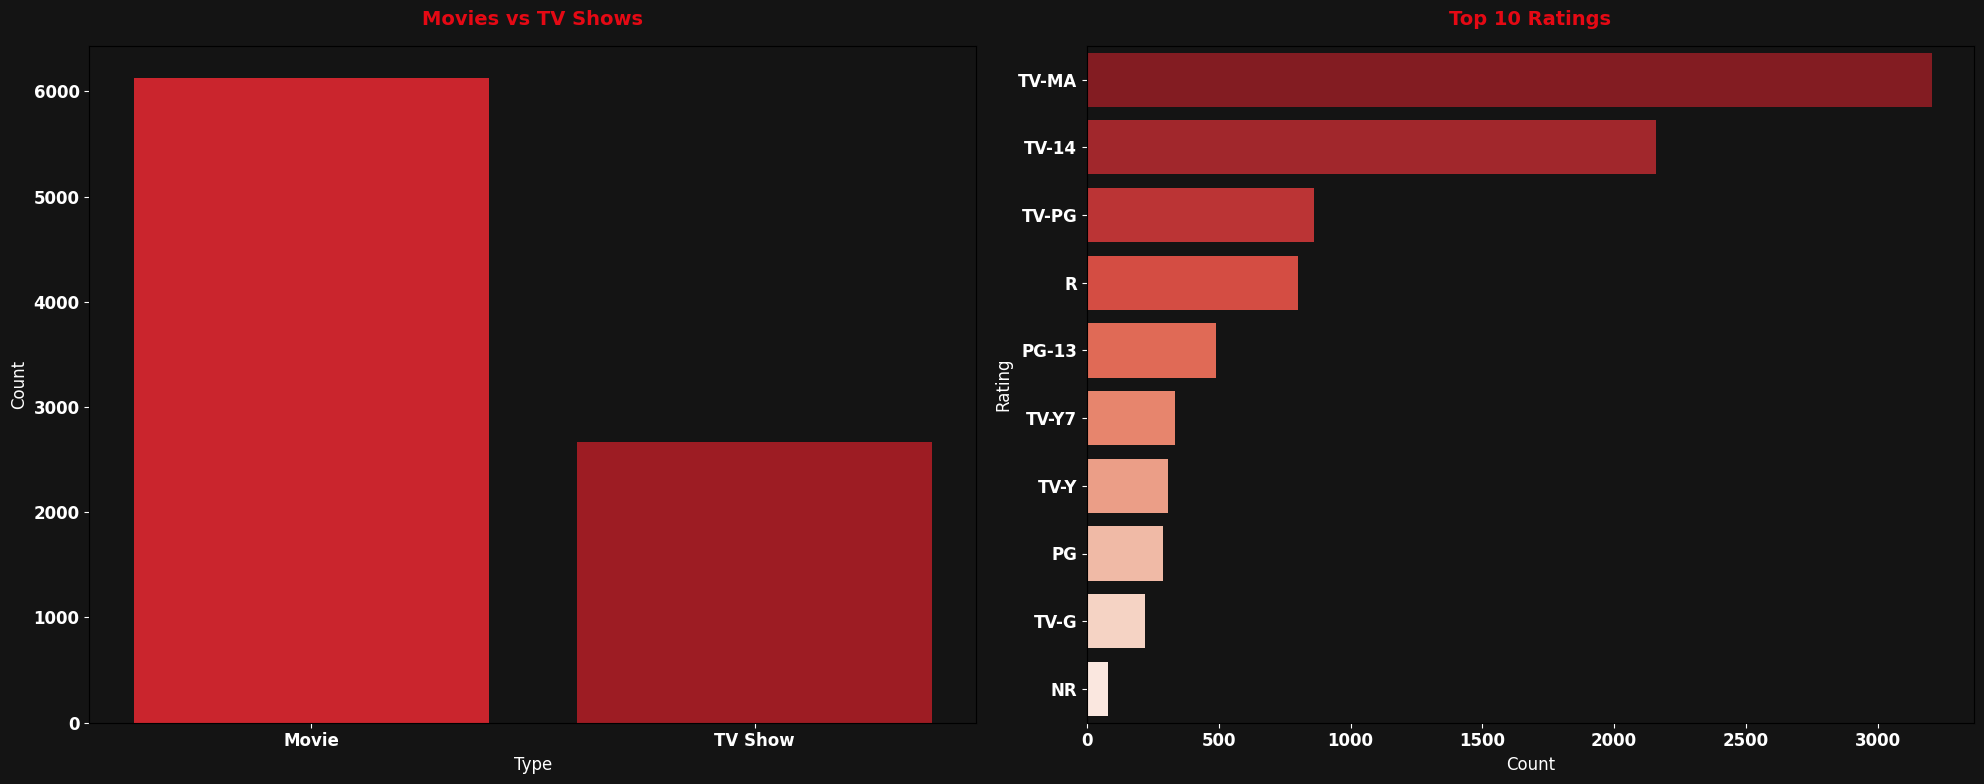

In [12]:
# === CONTENT TYPE & TOP 10 RATINGS ===
plt.figure(figsize=(20, 8))

# 1. Content Type
plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=df, x='type', palette=[netflix_red, '#B20710'])
ax1.set_facecolor(netflix_dark)
plt.gcf().set_facecolor(netflix_dark)
plt.title('Movies vs TV Shows', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Type', color='white')
plt.ylabel('Count', color='white')
plt.xticks(color='white')
plt.yticks(color='white')

# 2. Top 10 Ratings
plt.subplot(1, 2, 2)
top_r = df['rating'].value_counts().head(10)
ax2 = sns.barplot(y=top_r.index, x=top_r.values, palette='Reds_r')
ax2.set_facecolor(netflix_dark)
plt.title('Top 10 Ratings', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Count', color='white')
plt.ylabel('Rating', color='white')
plt.xticks(color='white')
plt.yticks(color='white')

plt.tight_layout()
plt.show()

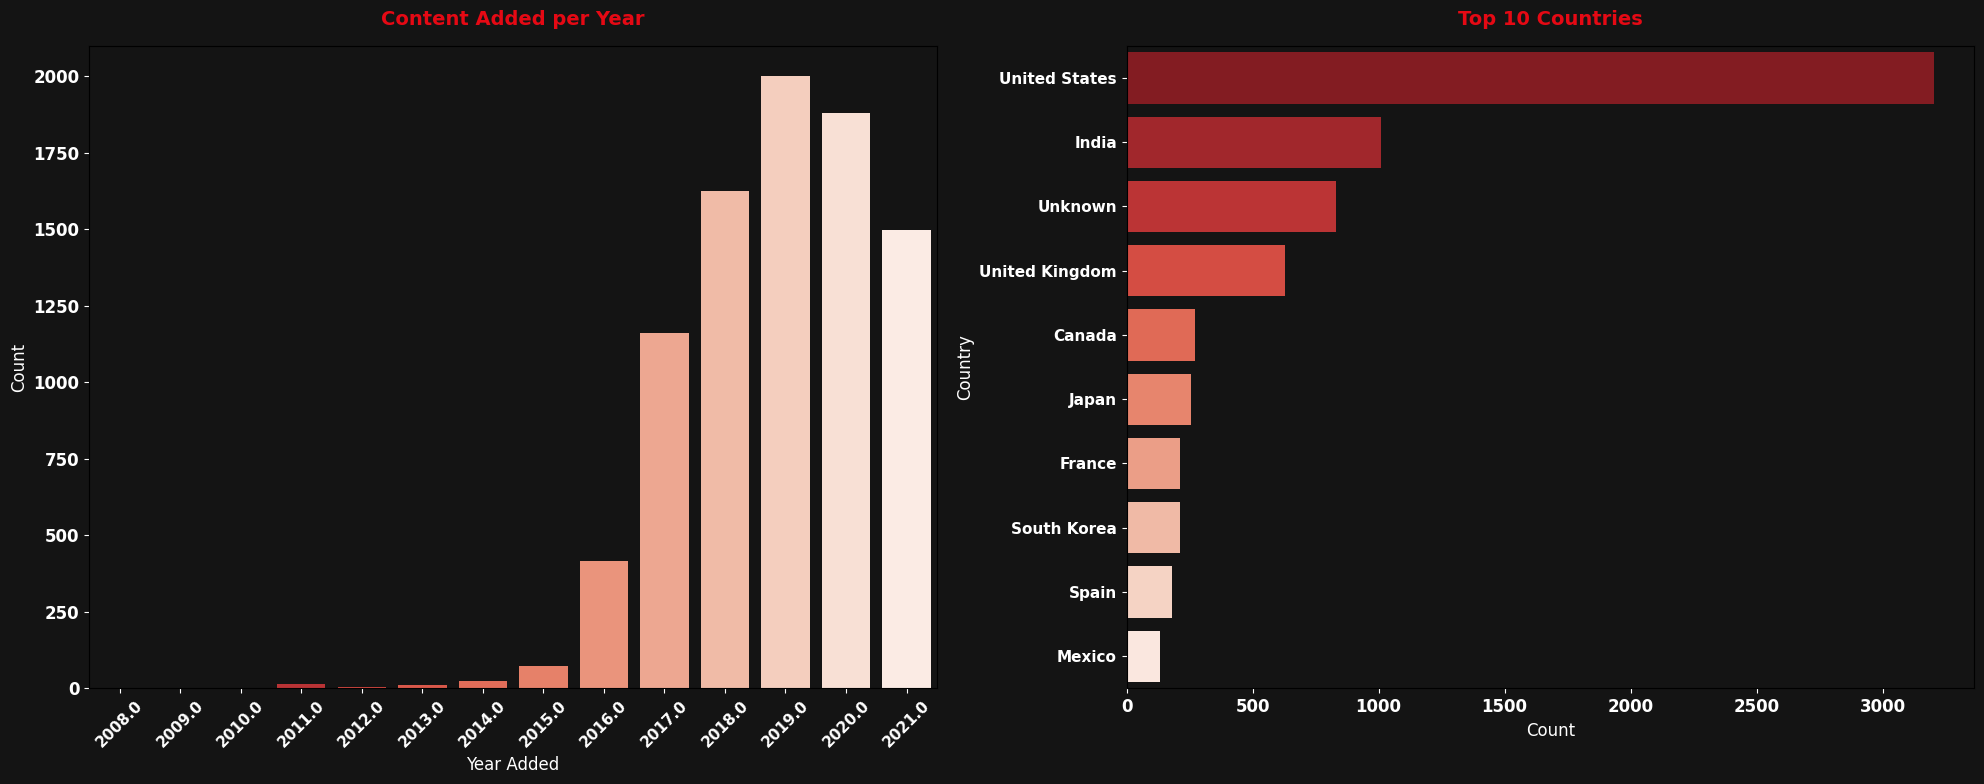

In [13]:
# === 3. CONTENT ADDED OVER TIME & 4. TOP 10 COUNTRIES ===
df['date_added_dt'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added_dt'].dt.year

plt.figure(figsize=(20, 8))

# 3. Content Added Over Time
plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=df, x='year_added', palette='Reds_r')
ax1.set_facecolor(netflix_dark)
plt.gcf().set_facecolor(netflix_dark)
plt.title('Content Added per Year', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Year Added', color='white')
plt.ylabel('Count', color='white')
plt.xticks(rotation=45, color='white', fontsize=11)
plt.yticks(color='white')

# 4. Top 10 Countries
df['country_main'] = df['country'].apply(lambda x: x.split(',')[0].strip() if pd.notna(x) else x)
top_c = df['country_main'].value_counts().head(10)
plt.subplot(1, 2, 2)
ax2 = sns.barplot(y=top_c.index, x=top_c.values, palette='Reds_r')
ax2.set_facecolor(netflix_dark)
plt.title('Top 10 Countries', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Count', color='white')
plt.ylabel('Country', color='white')
plt.xticks(color='white')
plt.yticks(color='white', fontsize=11)

plt.tight_layout()
plt.show()

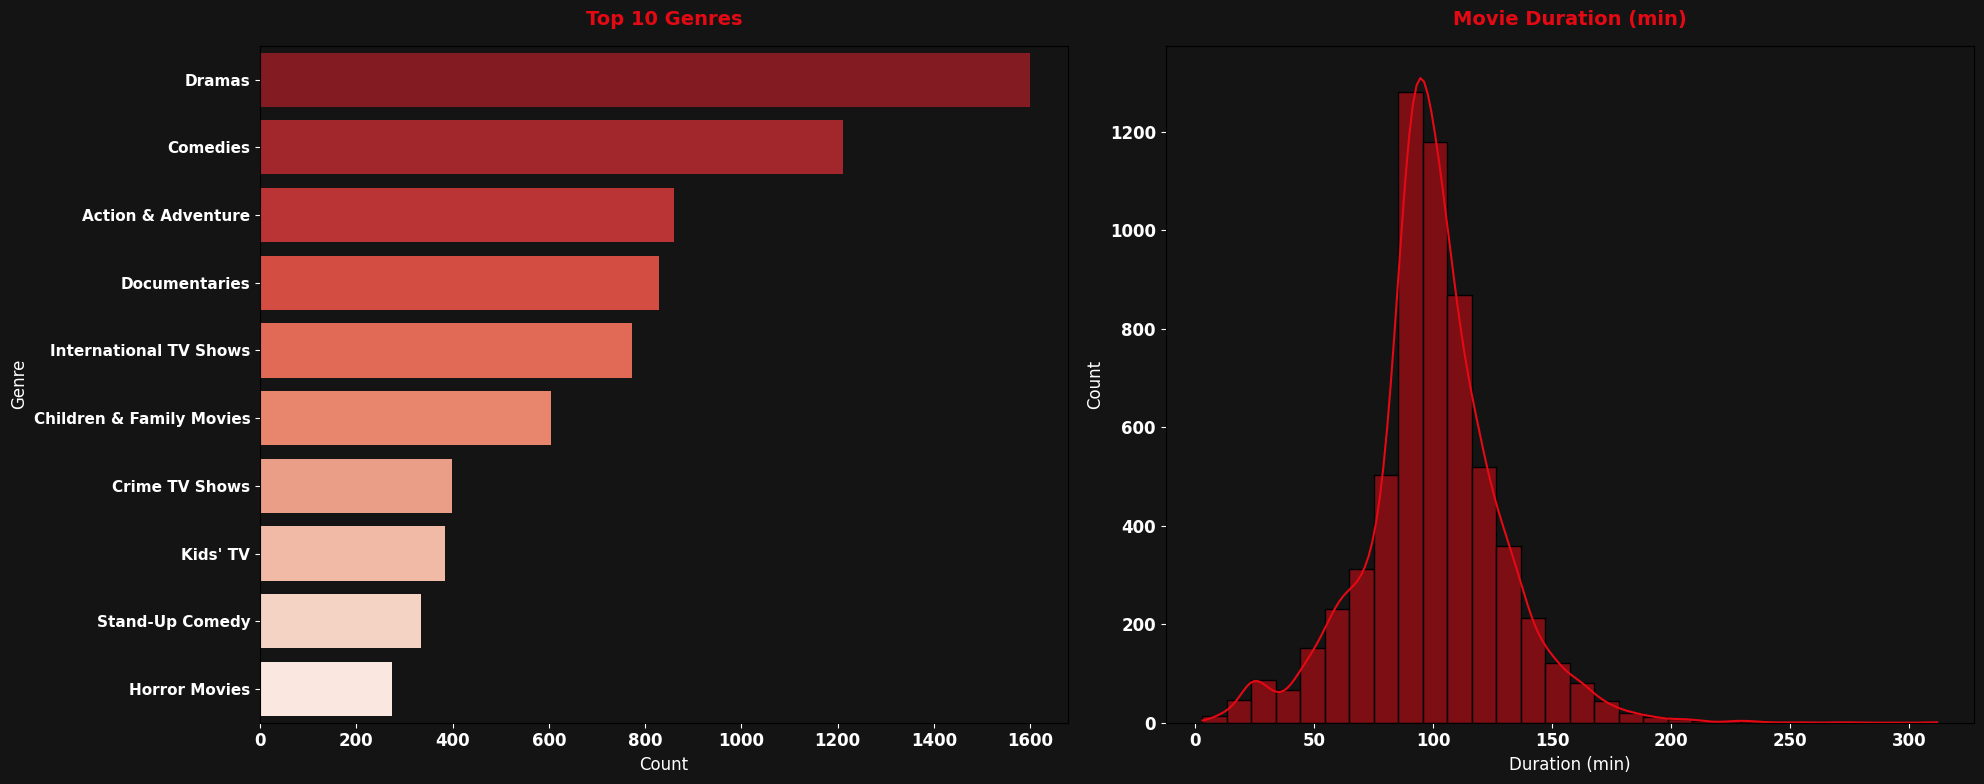

In [14]:
# === 5. TOP 10 GENRES & 6. MOVIE DURATION ===
df['primary_genre'] = df['listed_in'].apply(lambda x: x.split(',')[0].strip() if pd.notna(x) else x)
df['duration_num'] = df['duration'].str.extract(r'(\d+)').astype(int, errors='ignore')

plt.figure(figsize=(20, 8))

# 5. Top 10 Genres
plt.subplot(1, 2, 1)
top_g = df['primary_genre'].value_counts().head(10)
ax1 = sns.barplot(y=top_g.index, x=top_g.values, palette='Reds_r')
ax1.set_facecolor(netflix_dark)
plt.gcf().set_facecolor(netflix_dark)
plt.title('Top 10 Genres', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Count', color='white')
plt.ylabel('Genre', color='white')
plt.xticks(color='white')
plt.yticks(color='white', fontsize=11)

# 6. Movie Duration
plt.subplot(1, 2, 2)
ax2 = sns.histplot(data=df[df['type'] == 'Movie'], x='duration_num', bins=30,
                   color=netflix_red, kde=True, line_kws={'color': '#B20710'})
ax2.set_facecolor(netflix_dark)
plt.title('Movie Duration (min)', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Duration (min)', color='white')
plt.ylabel('Count', color='white')
plt.xticks(color='white')
plt.yticks(color='white')

plt.tight_layout()
plt.show()

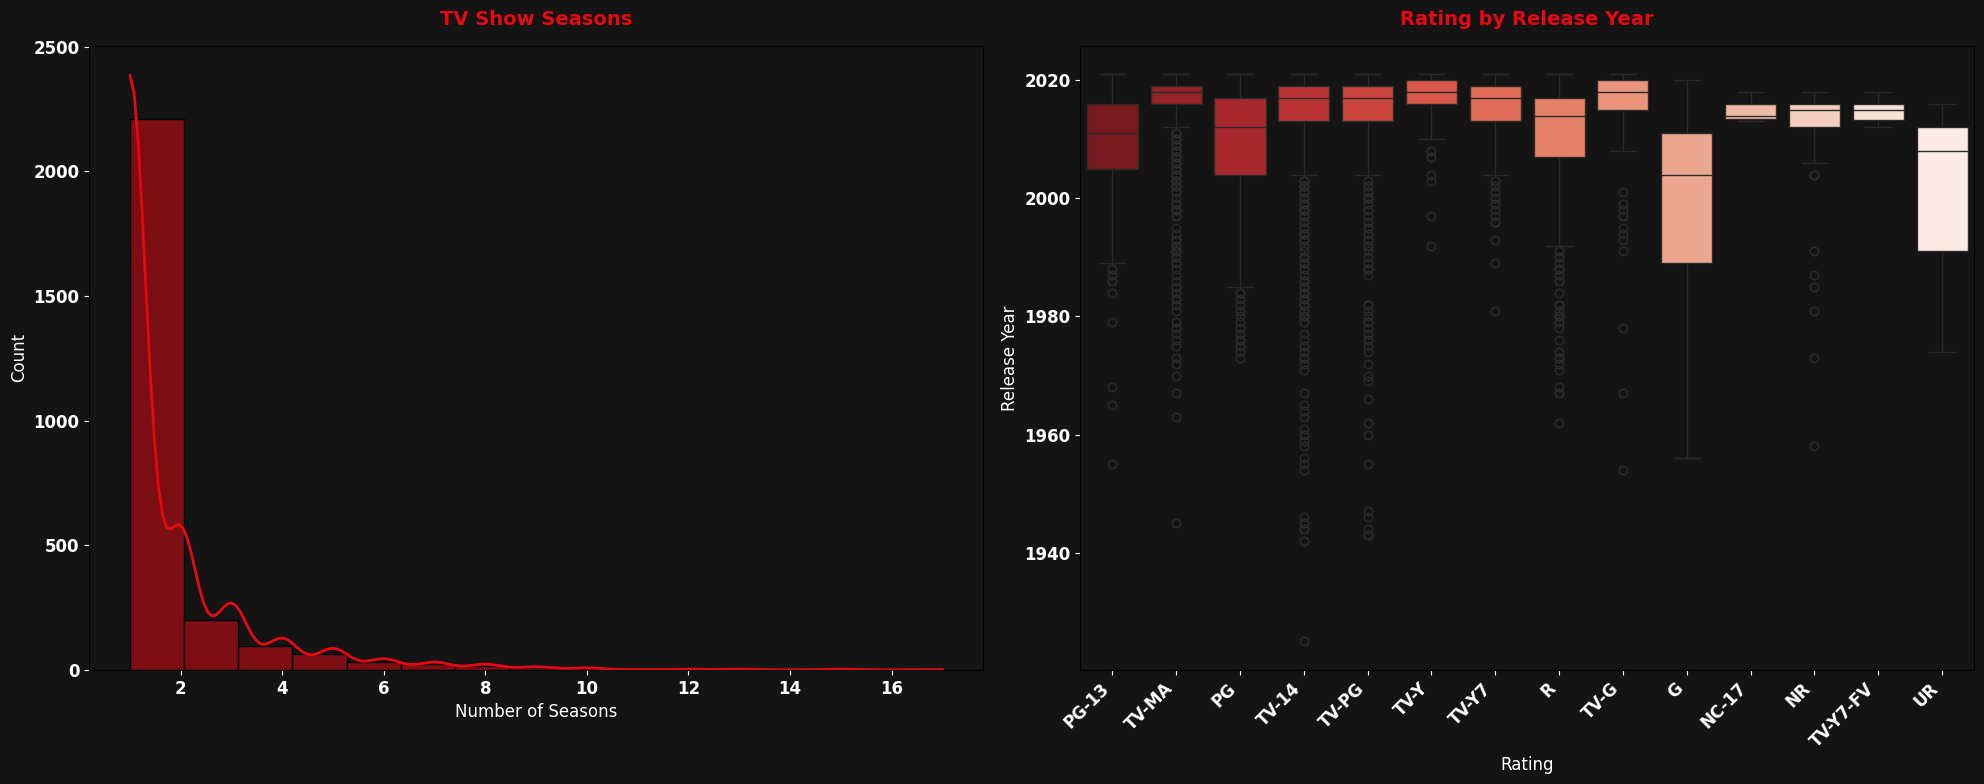

In [15]:
# === 7. TV SHOW SEASONS & 8. RATING BY RELEASE YEAR ===
plt.figure(figsize=(20, 8))

# 7. TV Show Seasons
plt.subplot(1, 2, 1)
ax1 = sns.histplot(data=df[df['type'] == 'TV Show'], x='duration_num', bins=15,
                   color=netflix_red, kde=True, line_kws={'color': '#B20710', 'linewidth': 2})
ax1.set_facecolor(netflix_dark)
plt.gcf().set_facecolor(netflix_dark)
plt.title('TV Show Seasons', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Number of Seasons', color='white')
plt.ylabel('Count', color='white')
plt.xticks(color='white')
plt.yticks(color='white')

# 8. Rating vs Release Year
plt.subplot(1, 2, 2)
ax2 = sns.boxplot(data=df, x='rating', y='release_year', palette='Reds_r')
ax2.set_facecolor(netflix_dark)
plt.title('Rating by Release Year', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Rating', color='white')
plt.ylabel('Release Year', color='white')
plt.xticks(rotation=45, color='white', ha='right')
plt.yticks(color='white')

plt.tight_layout()
plt.show()

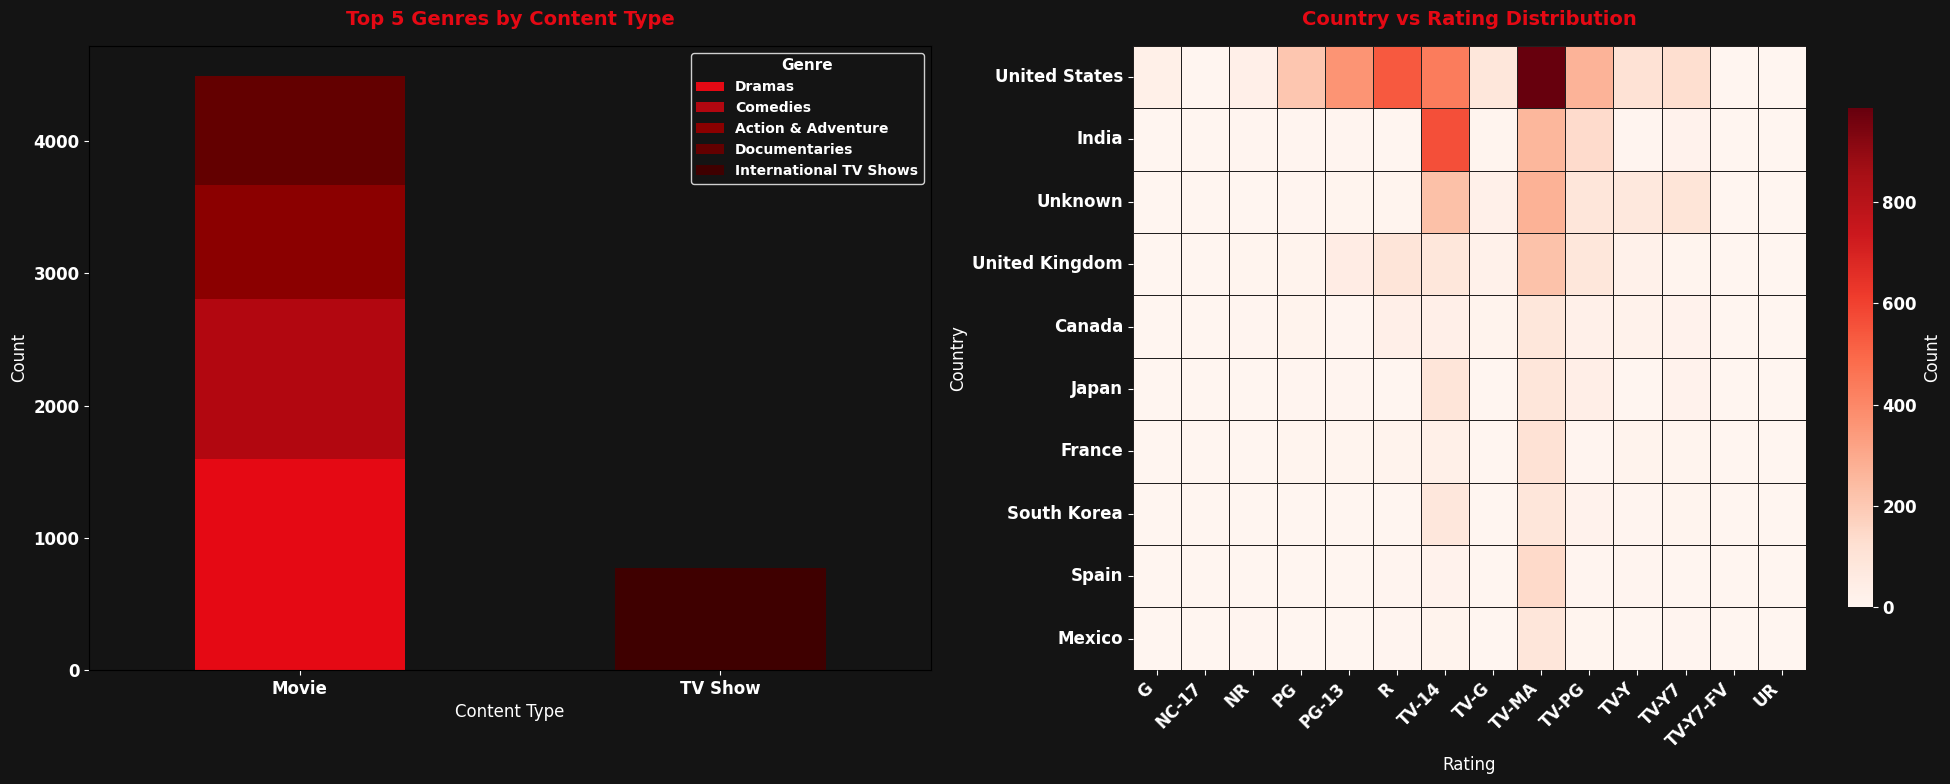

In [16]:
# === 9. GENRE BY TYPE & 10. COUNTRY VS RATING HEATMAP ===
plt.figure(figsize=(20, 8))

# 9. Genre by Type
plt.subplot(1, 2, 1)
genre_type = df.groupby(['type', 'primary_genre']).size().unstack(fill_value=0)
top_genres = genre_type.sum().sort_values(ascending=False).head(5).index
genre_type_top = genre_type[top_genres]

ax1 = genre_type_top.plot(kind='bar', stacked=True, ax=plt.gca(),
                          color=['#E50914', '#B20710', '#8B0000', '#630000', '#3F0000'],
                          edgecolor='none')
ax1.set_facecolor(netflix_dark)
plt.gcf().set_facecolor(netflix_dark)
plt.title('Top 5 Genres by Content Type', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Content Type', color='white')
plt.ylabel('Count', color='white')
plt.xticks(rotation=0, color='white', weight='bold')
plt.yticks(color='white')
plt.legend(title='Genre', title_fontsize=11, fontsize=10, facecolor=netflix_dark, edgecolor='white', labelcolor='white')

# 10. Country vs Rating Heatmap
plt.subplot(1, 2, 2)
pivot = df[df['country_main'].isin(top_c.index)].pivot_table(
    index='country_main', columns='rating', aggfunc='size', fill_value=0
)
pivot = pivot.loc[top_c.index]

ax2 = sns.heatmap(pivot, cmap='Reds', linewidths=0.5, linecolor=netflix_gray,
                  cbar_kws={'label': 'Count', 'shrink': 0.8})
ax2.set_facecolor(netflix_dark)
plt.title('Country vs Rating Distribution', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Rating', color='white')
plt.ylabel('Country', color='white')
cbar = ax2.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
plt.xticks(rotation=45, ha='right', color='white')
plt.yticks(color='white')

plt.tight_layout()
plt.show()

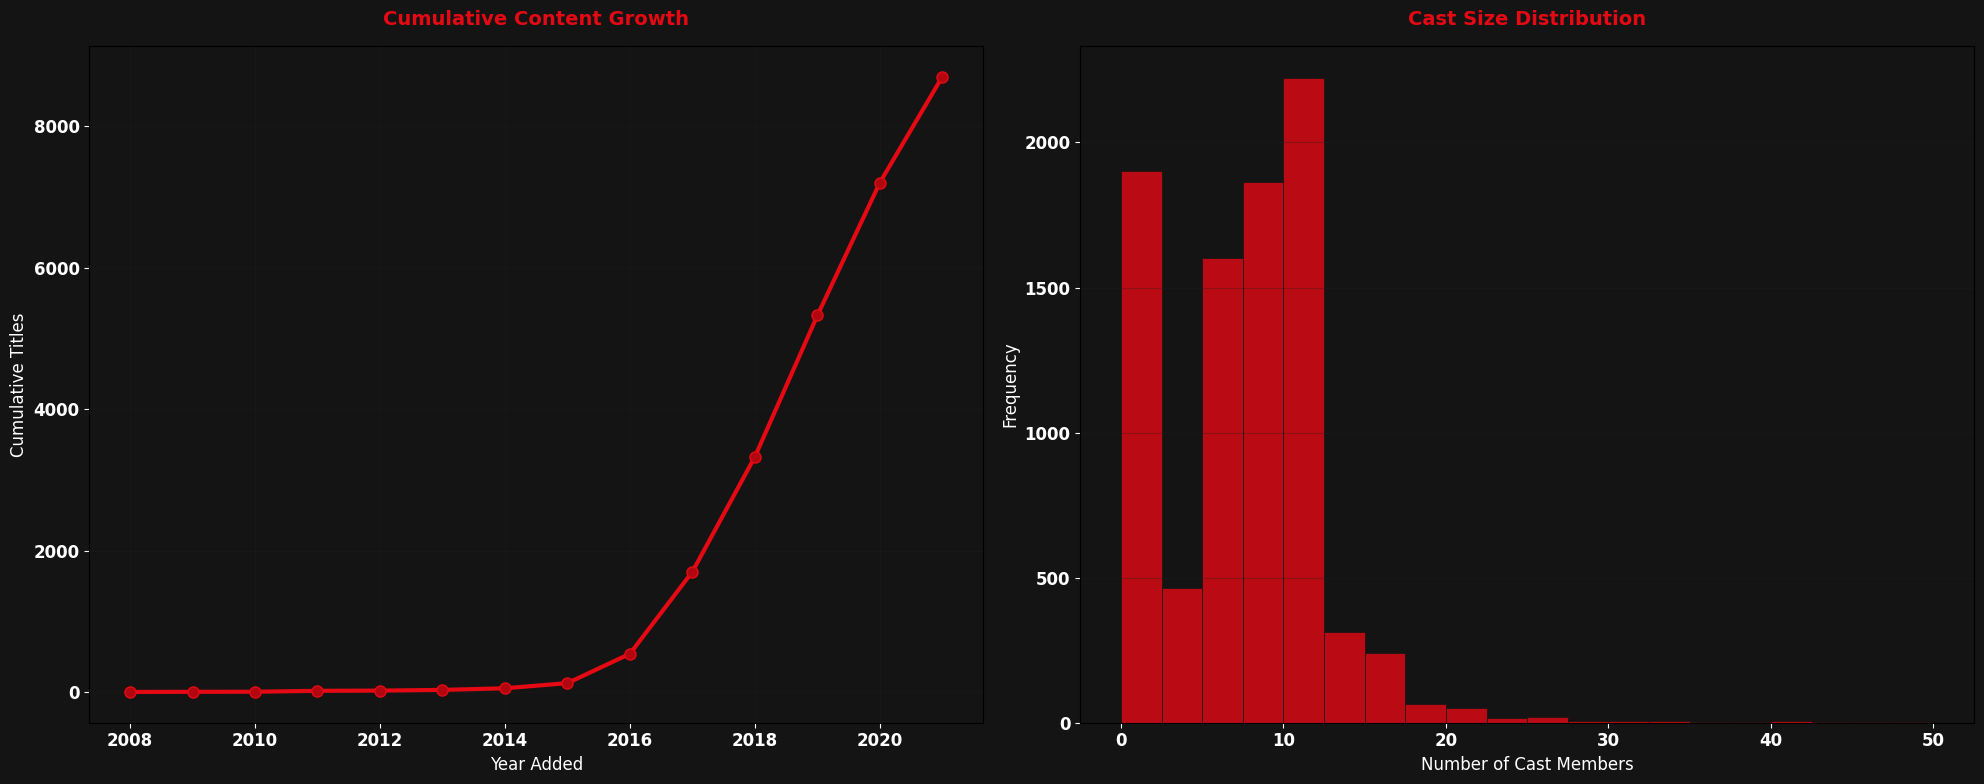

In [17]:
# === 11. CUMULATIVE GROWTH & 12. CAST SIZE DISTRIBUTION ===
plt.figure(figsize=(20, 8))

# 11. Cumulative Growth
plt.subplot(1, 2, 1)
cum = df['year_added'].value_counts().sort_index().cumsum()
ax1 = cum.plot(kind='line', marker='o', color=netflix_red, linewidth=3, markersize=8, markerfacecolor='#B20710')
ax1.set_facecolor(netflix_dark)
plt.gcf().set_facecolor(netflix_dark)
plt.title('Cumulative Content Growth', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Year Added', color='white')
plt.ylabel('Cumulative Titles', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(True, alpha=0.3, color=netflix_gray)

# 12. Cast Size Distribution
df['cast_size'] = df['cast'].apply(lambda x: len(x.split(',')) if pd.notna(x) and x != 'Unknown' else 0)
plt.subplot(1, 2, 2)
ax2 = sns.histplot(df['cast_size'], bins=20, color=netflix_red, alpha=0.8, edgecolor=netflix_dark, linewidth=0.5)
ax2.set_facecolor(netflix_dark)
plt.title('Cast Size Distribution', color=netflix_red, fontsize=14, weight='bold', pad=15)
plt.xlabel('Number of Cast Members', color='white')
plt.ylabel('Frequency', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(axis='y', alpha=0.3, color=netflix_gray)

plt.tight_layout()
plt.show()

## 🧠 Machine Learning Feature Creation</font>

We create additional features for ML tasks such as:  
- Title length  
- Description length  
- Days since added  
- Sentiment cues from description text


In [18]:
# Numeric
df['title_len'] = df['title'].str.len()
df['desc_len'] = df['description'].str.len()
df['days_since_added'] = (df['date_added_dt'].max() - df['date_added_dt']).dt.days.fillna(0)

# Sentiment cues
pos_words = ['love','great','best','amazing','excellent','brilliant','heart','family','friend']
neg_words = ['kill','death','dark','fear','horror','blood','war','crime','violence']
df['desc_pos'] = df['description'].apply(lambda x: sum(w in x.lower() for w in pos_words))
df['desc_neg'] = df['description'].apply(lambda x: sum(w in x.lower() for w in neg_words))
df['is_international'] = df['listed_in'].str.contains('International', case=False).astype(int)

numeric_cols = ['release_year','year_added','duration_num','cast_size','title_len','desc_len','days_since_added','desc_pos','desc_neg','is_international']
X_num = df[numeric_cols].fillna(0).astype(float)
X_type = pd.get_dummies(df['type'], prefix='type', drop_first=True, dtype=int)

# TF-IDF
tfidf_desc    = TfidfVectorizer(max_features=1200, stop_words='english', ngram_range=(1,2))
tfidf_genre   = TfidfVectorizer(max_features=120)
tfidf_cast    = TfidfVectorizer(max_features=250)
tfidf_dir     = TfidfVectorizer(max_features=180)
tfidf_country = TfidfVectorizer(max_features=120)

X_desc    = tfidf_desc.fit_transform(df['description'])
X_genre   = tfidf_genre.fit_transform(df['listed_in'])
X_cast    = tfidf_cast.fit_transform(df['cast'])
X_dir     = tfidf_dir.fit_transform(df['director'])
X_country = tfidf_country.fit_transform(df['country'])

# Final X
X = hstack([X_num, X_type, X_desc, X_genre, X_cast, X_dir, X_country])
print(f"Final Features: {X.shape[1]}")

Final Features: 1806


## 🤖 Step 10: LightGBM Model Training</font>

We train classification models to predict:
- **Age Group** (target: rating category)  
- Using LightGBM for efficient gradient boosting on structured data.


In [19]:
# Age Group
age_map = {'TV-Y':'Kids','TV-Y7':'Kids','TV-G':'Kids','G':'Kids','TV-PG':'Teens','PG':'Teens','PG-13':'Teens','TV-14':'Young Adults','TV-MA':'Adults','R':'Adults','NC-17':'Adults'}
df['age_group'] = df['rating'].map(age_map).fillna('Adults')
le_age = LabelEncoder(); y_age = le_age.fit_transform(df['age_group'])

# Maturity Rating
top6 = df['rating'].value_counts().head(6).index
df['rating_simp'] = df['rating'].apply(lambda x: x if x in top6 else 'Other')
le_rating = LabelEncoder(); y_rating = le_rating.fit_transform(df['rating_simp'])

# Country
top10 = df['country_main'].value_counts().head(10).index
df['country_main_simp'] = df['country_main'].apply(lambda x: x if x in top10 else 'Other')
le_country = LabelEncoder(); y_country = le_country.fit_transform(df['country_main_simp'])


========================= Age Group =========================
Accuracy: 0.6655
              precision    recall  f1-score   support

      Adults       0.69      0.83      0.75       901
        Kids       0.83      0.78      0.80       198
       Teens       0.61      0.40      0.49       360
Young Adults       0.56      0.51      0.54       475

    accuracy                           0.67      1934
   macro avg       0.67      0.63      0.64      1934
weighted avg       0.66      0.67      0.65      1934



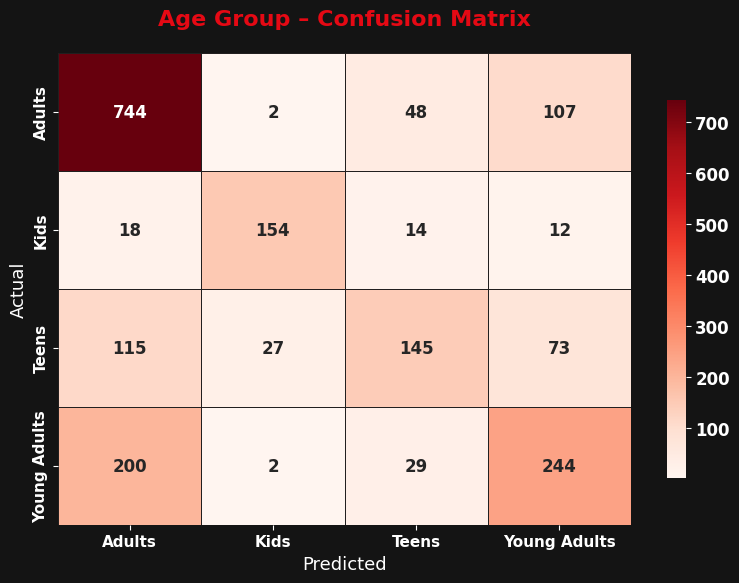


========================= Maturity Rating =========================
Accuracy: 0.5905
              precision    recall  f1-score   support

       Other       0.68      0.56      0.61       208
       PG-13       0.53      0.36      0.43       108
           R       0.57      0.61      0.59       176
       TV-14       0.55      0.57      0.56       475
       TV-MA       0.62      0.76      0.68       705
       TV-PG       0.38      0.14      0.21       189
       TV-Y7       0.67      0.59      0.63        73

    accuracy                           0.59      1934
   macro avg       0.57      0.51      0.53      1934
weighted avg       0.58      0.59      0.57      1934



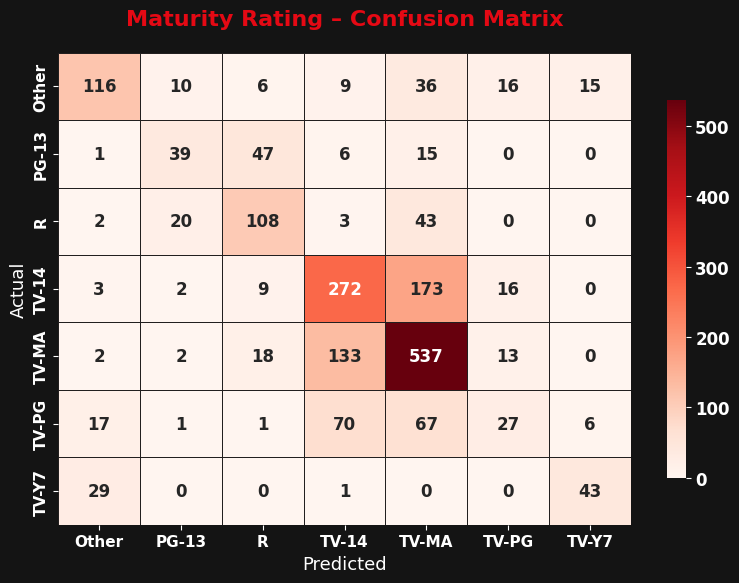


========================= Primary Country =========================
Accuracy: 0.9421
                precision    recall  f1-score   support

        Canada       0.94      0.73      0.82        60
        France       0.86      0.81      0.84        47
         India       0.99      1.00      1.00       222
         Japan       1.00      0.93      0.96        57
        Mexico       0.96      0.90      0.93        29
         Other       0.95      0.93      0.94       409
   South Korea       0.96      1.00      0.98        46
         Spain       0.88      0.93      0.90        40
United Kingdom       0.85      0.87      0.86       138
 United States       0.93      0.96      0.94       704
       Unknown       1.00      1.00      1.00       182

      accuracy                           0.94      1934
     macro avg       0.94      0.91      0.92      1934
  weighted avg       0.94      0.94      0.94      1934



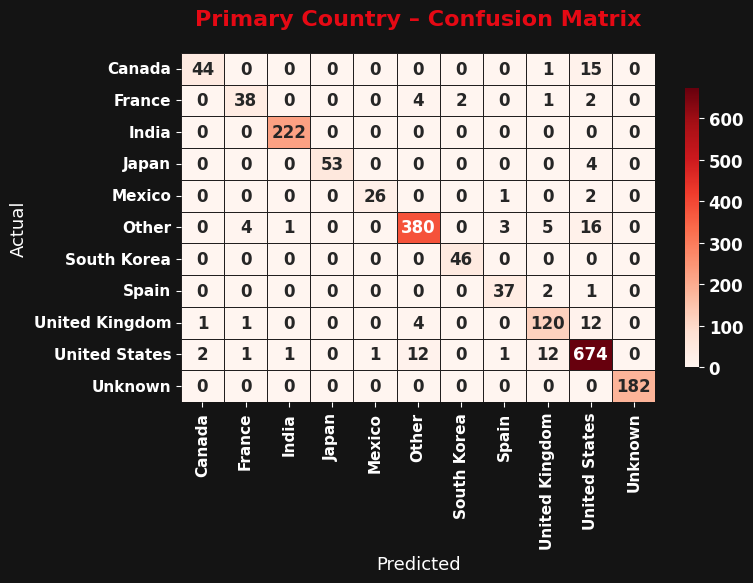

In [20]:
def train_lgb(X, y, le, name):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.22, stratify=y, random_state=42)
    train_data = lgb.Dataset(X_tr, label=y_tr)
    val_data   = lgb.Dataset(X_te, label=y_te, reference=train_data)

    params = {
        'objective': 'multiclass', 'num_class': len(le.classes_),
        'metric': 'multi_logloss', 'learning_rate': 0.03,
        'num_leaves': 128, 'max_depth': -1, 'min_data_in_leaf': 20,
        'feature_fraction': 0.75, 'bagging_fraction': 0.75, 'bagging_freq': 5,
        'lambda_l1': 0.1, 'lambda_l2': 0.1, 'verbosity': -1, 'seed': 42
    }

    model = lgb.train(params, train_data, valid_sets=[val_data], num_boost_round=2000,
                      callbacks=[lgb.early_stopping(100, verbose=False)])

    pred = np.argmax(model.predict(X_te), axis=1)
    acc = accuracy_score(y_te, pred)

    print(f"\n{'='*25} {name} {'='*25}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_te, pred, target_names=le.classes_, zero_division=0))

    # === CONFUSION MATRIX (Netflix Dark & Red Theme) ===
    cm = confusion_matrix(y_te, pred)
    plt.figure(figsize=(8, 6))

    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                    xticklabels=le.classes_, yticklabels=le.classes_,
                    linewidths=0.5, linecolor=netflix_gray,
                    cbar_kws={'shrink': 0.8})

    ax.set_facecolor(netflix_dark)
    plt.gcf().set_facecolor(netflix_dark)
    plt.title(f"{name} – Confusion Matrix", color=netflix_red, fontsize=16, weight='bold', pad=20)
    plt.xlabel('Predicted', color='white', fontsize=13)
    plt.ylabel('Actual', color='white', fontsize=13)
    plt.xticks(color='white', fontsize=11, weight='bold')
    plt.yticks(color='white', fontsize=11, weight='bold')

    # Style colorbar
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

    plt.tight_layout()
    plt.show()

    return model, acc

# Train
lgb_age,     acc_age     = train_lgb(X, y_age,     le_age,     "Age Group")
lgb_rating,  acc_rating  = train_lgb(X, y_rating,  le_rating,  "Maturity Rating")
lgb_country, acc_country = train_lgb(X, y_country, le_country, "Primary Country")

## 📊 Step 11: Feature Importance & Final Insights</font>

We visualize the most important features influencing the prediction  
and summarize key takeaways from our entire analysis.

Generating 3 Netflix-Branded Feature Importance Plots...



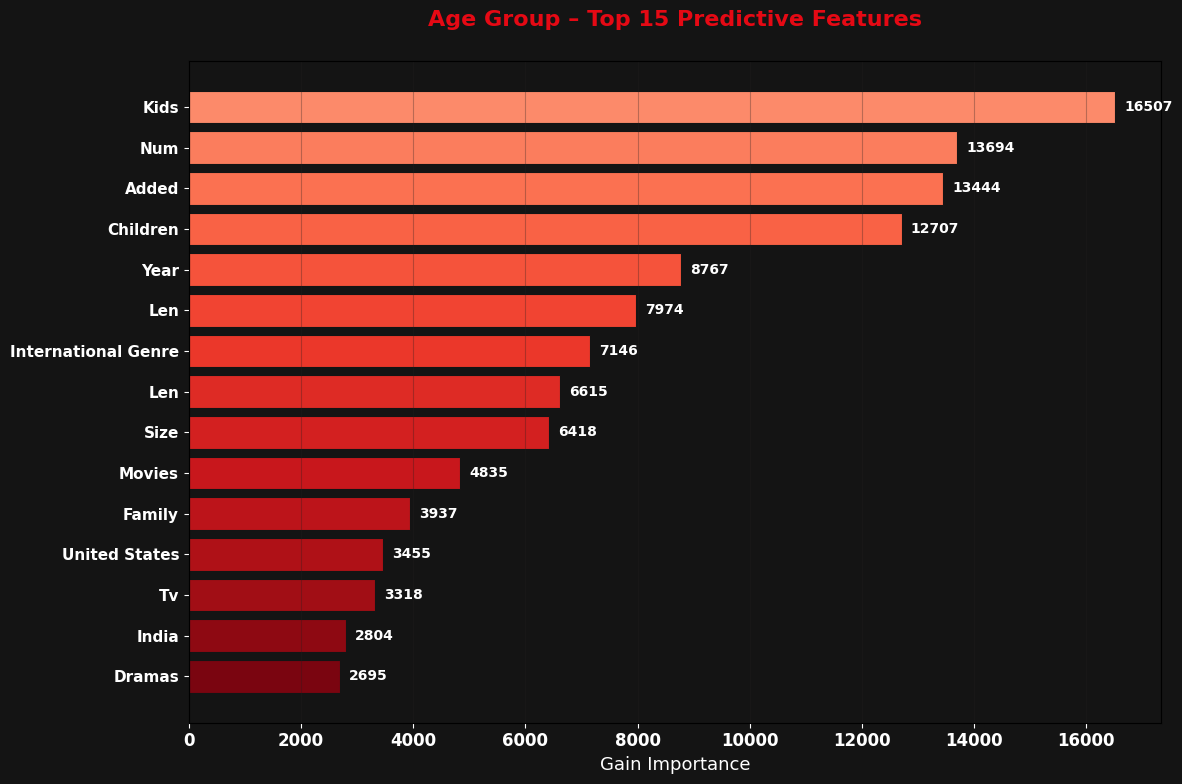

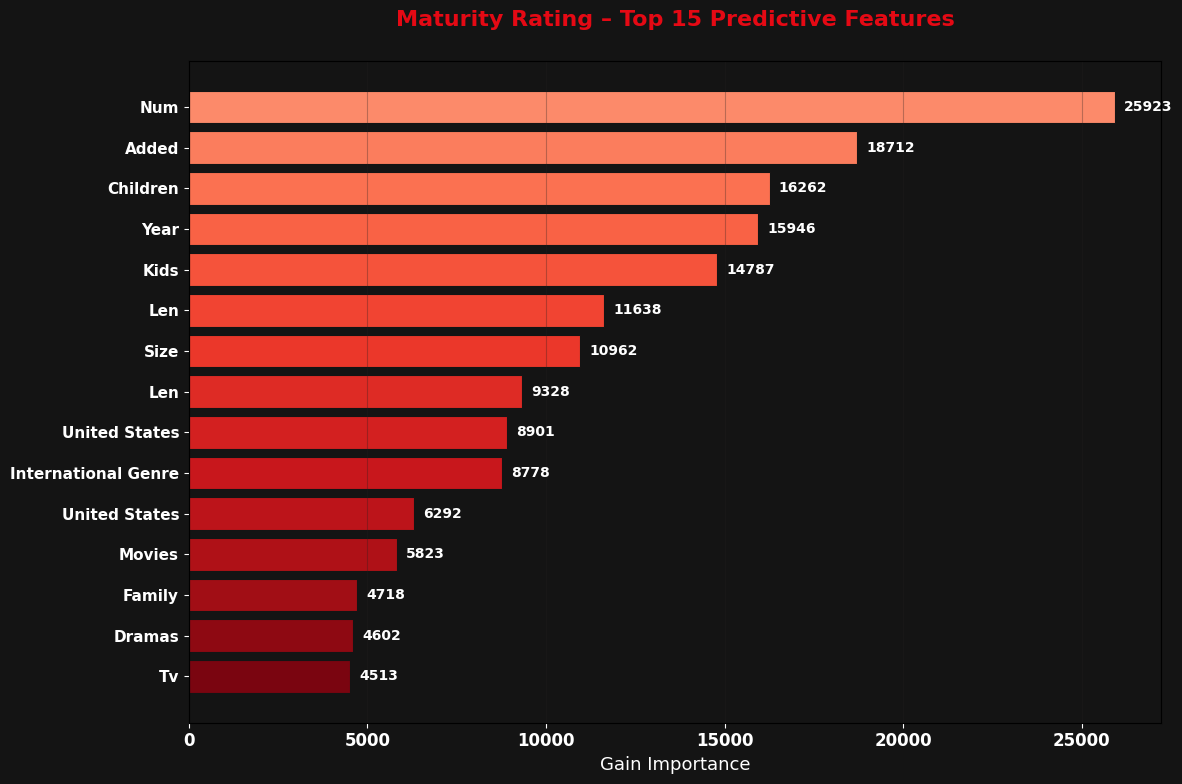

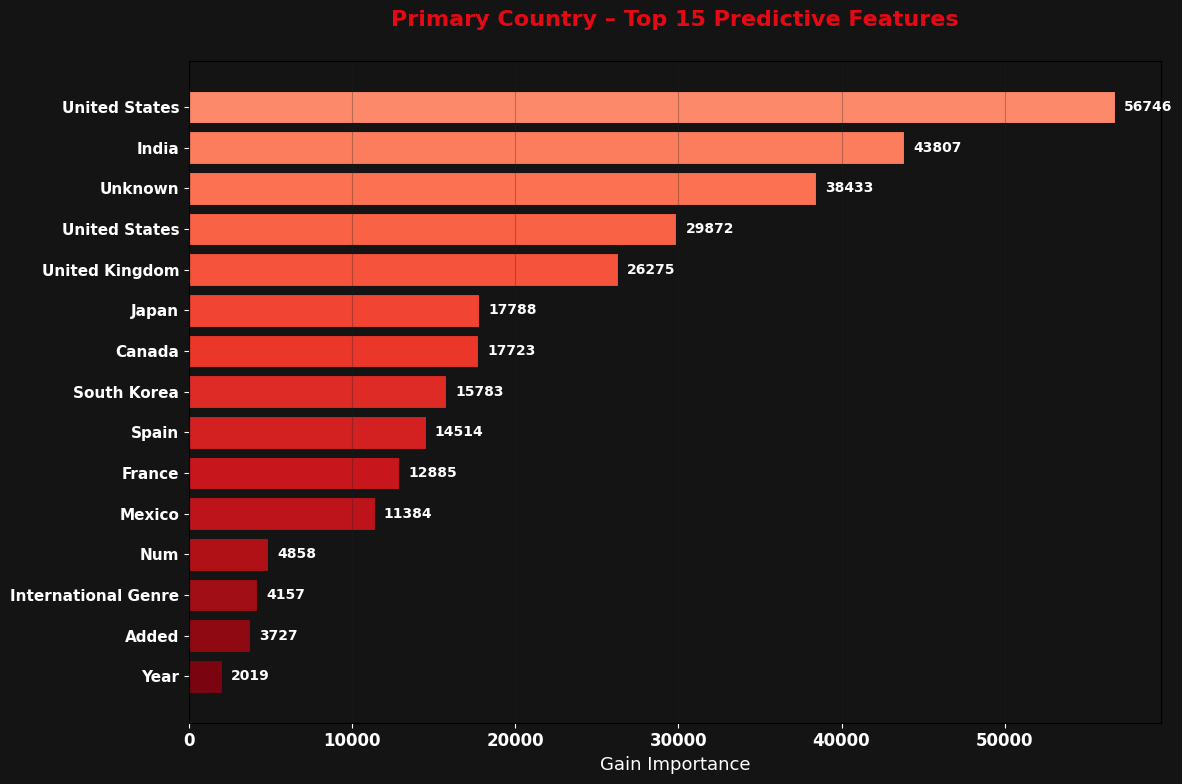

In [21]:
# FEATURE IMPORTANCE PLOTS

import matplotlib.pyplot as plt
import numpy as np

feature_names = (
    numeric_cols +
    list(X_type.columns) +
    tfidf_desc.get_feature_names_out().tolist() +
    tfidf_genre.get_feature_names_out().tolist() +
    tfidf_cast.get_feature_names_out().tolist() +
    tfidf_dir.get_feature_names_out().tolist() +
    tfidf_country.get_feature_names_out().tolist()
)

label_map = {
    'states': 'United States',
    'united': 'United States',
    'kingdom': 'United Kingdom',
    'india': 'India',
    'japan': 'Japan',
    'canada': 'Canada',
    'uk': 'United Kingdom',
    'us': 'United States',
    'korea': 'South Korea',
    'spain': 'Spain',
    'france': 'France',
    'mexico': 'Mexico',
    'unknown': 'Unknown',
    'germany': 'Germany',
    'australia': 'Australia',
    'brazil': 'Brazil',
    'italy': 'Italy',
    # Numeric
    'duration_num': 'Duration',
    'days_since_added': 'Days Since Added',
    'release_year': 'Release Year',
    'year_added': 'Year Added',
    'cast_size': 'Cast Size',
    'title_len': 'Title Length',
    'desc_len': 'Description Length',
    'desc_pos': 'Positive Sentiment',
    'desc_neg': 'Negative Sentiment',
    'is_international': 'International Content',
    # Type
    'type_tv show': 'TV Show',
    # Genre examples
    'drama': 'Drama Genre',
    'comedy': 'Comedy Genre',
    'documentary': 'Documentary',
    'action': 'Action',
    'international': 'International Genre',
    # Cast/Director (common names)
    'smith': 'Cast: Smith',
    'johnson': 'Cast: Johnson',
    'lee': 'Cast: Lee',
}

def clean_label(raw):
    """Convert raw feature name to clean, readable label"""
    base = raw.split('_')[-1].lower().strip()
    return label_map.get(base, base.title())

# === FEATURE IMPORTANCE PLOTS ===
def plot_importance(model, le, name, top_n=15):
    importances = model.feature_importance(importance_type='gain')
    indices = np.argsort(importances)[-top_n:][::-1]

    feats = [feature_names[i] for i in indices]
    imps = importances[indices]
    clean_labels = [clean_label(f) for f in feats]

    plt.figure(figsize=(12, 8))
    ax = plt.gca()
    ax.set_facecolor(netflix_dark)
    plt.gcf().set_facecolor(netflix_dark)

    bars = plt.barh(range(top_n), imps,
                    color=[plt.cm.Reds(0.4 + 0.6 * (i / top_n)) for i in range(top_n)],
                    edgecolor=netflix_dark, linewidth=0.8)

    plt.yticks(range(top_n), clean_labels, fontsize=11, color='white', weight='bold')
    plt.xlabel('Gain Importance', fontsize=13, color='white')
    plt.title(f'{name} – Top {top_n} Predictive Features',
              fontsize=16, color=netflix_red, weight='bold', pad=25)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3, color=netflix_gray)

    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + max(imps)*0.01, bar.get_y() + bar.get_height()/2,
                 f'{imps[i]:.0f}', va='center', ha='left', fontsize=10,
                 color='white', weight='bold')

    plt.tight_layout()
    plt.show()

print("Generating 3 Netflix-Branded Feature Importance Plots...\n")
plot_importance(lgb_age,     le_age,     "Age Group")
plot_importance(lgb_rating,  le_rating,  "Maturity Rating")
plot_importance(lgb_country, le_country, "Primary Country")

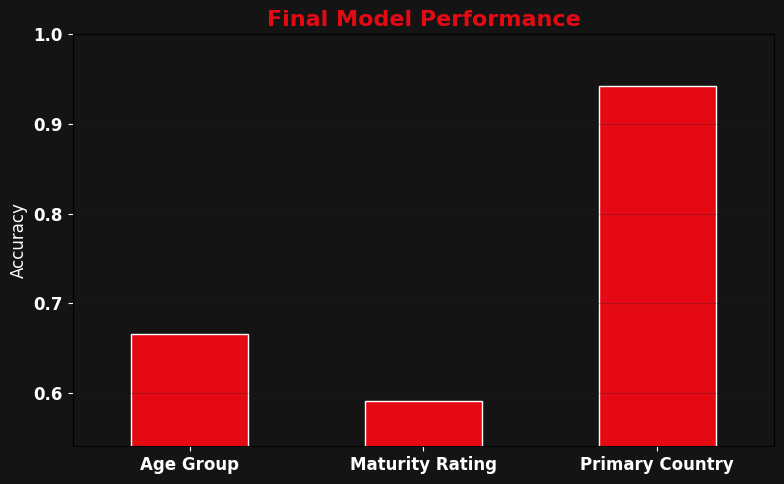


FINAL SUMMARY (High-Accuracy LightGBM)


,Classes,Accuracy
Task,,
Age Group,4,0.665500
Maturity Rating,7,0.590500
Primary Country,11,0.942100


In [22]:
summary = pd.DataFrame({
    'Task': ['Age Group', 'Maturity Rating', 'Primary Country'],
    'Classes': [4, 7, 11],
    'Accuracy': [acc_age, acc_rating, acc_country]
}).set_index('Task')

fig, ax = plt.subplots(figsize=(8, 5))

summary['Accuracy'].plot(
    kind='bar',
    ax=ax,
    color=netflix_red,
    title="Final Model Performance",
    edgecolor='white'
)

ax.set_facecolor(netflix_dark)
plt.gcf().set_facecolor(netflix_dark)

plt.title('Final Model Performance', color=netflix_red, fontsize=16, weight='bold')
plt.ylabel('Accuracy', color='white')
plt.xlabel('', color='white')
plt.xticks(rotation=0, color='white', weight='bold')
plt.yticks(color='white')

min_acc = summary['Accuracy'].min() - 0.05
plt.ylim(min_acc, 1.0)

plt.grid(axis='y', alpha=0.25, color=netflix_gray)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("FINAL SUMMARY (High-Accuracy LightGBM)")
print("="*60)
_ = display(netflix_styled_table(summary.round(4), "Model Performance Summary"))